In [1]:
%matplotlib inline

### Wczytanie niezbędnych bibliotek

In [6]:
import re
import time

import numpy as np
import pandas as pd
import nltk
import gensim

import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm

from pyMorfologik import Morfologik
from pyMorfologik.parsing import ListParser

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers import Conv1D, Flatten, Dropout, Dense, LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils

Using TensorFlow backend.


### Definicja klasy procesującej dokumenty.

In [7]:
class TokenizedDataFrame():
    __slots__ = ['stopwords', 'stemmed_dict']
    
    def __init__(self, stopwords):
        self.stopwords = stopwords
        self.stemmed_dict = None
        
    
    def prepare_text(self, doc):
        doc = re.sub(r'[^\w\s]','',doc)
        doc = doc.lower()
        doc = nltk.word_tokenize(doc)
        doc = [word for word in doc if word not in self.stopwords]
        return doc
    
    
    def apply_stemming(self, df):
        all_words = list()

        for item in list(df):
            all_words.extend(item)
    
        unique_words = list(set(all_words))
        
        self.stemmed_dict = dict()
        unique_words_stemmer = stemmer.stem(unique_words, parser)

        for item in unique_words_stemmer:
            original = item[0]
            try:
                stemmed = list(item[1])[0]
                self.stemmed_dict[original] = stemmed
            except IndexError:
                self.stemmed_dict[original] = stemmed
        
        
        missings = {item:item for item in unique_words if item not in self.stemmed_dict.keys()}
        self.stemmed_dict.update(missings)
        
        
    @staticmethod
    def remove_empty(df, col):
        return df.loc[df[col].apply(lambda x: len(x)) > 0, :]
    
       
    def transform(self, X, col, **kwargs):
        try:
            X_local = X.copy()
            X_local[col] = X_local[col].apply(self.prepare_text)
            X_local = self.remove_empty(X_local, col)
        except KeyError:
            raise KeyError("{} not present in dataframe".format(col))
            
        if not self.stemmed_dict:
            self.apply_stemming(X_local[col])
            
        X_local[col] = X_local[col].apply(lambda doc: list(map(self.stemmed_dict.get, doc)))
        X_local = X_local.reset_index(drop=True)
        
        return X_local

### Zdefiniowanie stałych

In [8]:
DATA_PATH = './data/learning_set.csv'
STOPWORDS_PATH = 'data/polish_stopwords.csv'
W2V_PATH = 'data/nkjp+wiki-forms-all-100-cbow-hs.txt'

RANDOM_STATE = 23032019

C_V = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

SCORING = 'accuracy'
N_JOBS = -1

### Wczytanie dokumentów

In [9]:
df = pd.read_csv(DATA_PATH, sep = ';')

In [10]:
df.groupby('sentiment').count()/df.shape[0]

,token
sentiment,
-1,0.102936
0,0.762434
1,0.134629


In [12]:
# import nltk
# nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rkobiela001\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [13]:
stopwords = list(pd.read_csv(STOPWORDS_PATH, engine='python', header=None).iloc[:, 0])

parser = ListParser()
stemmer = Morfologik()

df = TokenizedDataFrame(stopwords).transform(df, 'token')

### Podział na zbiór treningowy/testowy

#### y_train/y_test używamy do sklearn API, dummy do Kerasa

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df.token, 
                                                    df.sentiment, 
                                                    test_size=0.15, 
                                                    shuffle=True,
                                                    random_state=RANDOM_STATE)

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
dummy_y_train = np_utils.to_categorical(encoded_y_train)
dummy_y_test = np_utils.to_categorical(encoded_y_test)

In [15]:
model_lr = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', tokenizer=lambda x: x,
                              preprocessor=lambda x: x, ngram_range=(1,2),
                              sublinear_tf=True)),
    ('lr', LogisticRegression(penalty='l2', random_state=RANDOM_STATE,
                              n_jobs=-1, multi_class='multinomial', solver='lbfgs')
                             )
])

model_lr.fit(x_train, y_train)


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2',
        preprocessor=<function <lam...ty='l2', random_state=23032019, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

### Ile wynosi null accuracy?

In [537]:
print("{:.1f}%".format(100*y_train.value_counts().max()/len(y_train)))

66.9%


### Jakie accuracy na 10-krotnej CV osiąga regresja logistyczna?

In [19]:
cross_validate(model_lr, 
               x_train,
               y_train,
               cv=C_V,
               scoring=SCORING,
               n_jobs=N_JOBS, 
               return_train_score=True)\
.get('test_score')\
.mean()

0.7551888160274167

### Accuracy na zbiorze testowym

In [20]:
accuracy_score(y_test, model_lr.predict(x_test))

0.7587994542974079

### Wykres krzywej uczenia

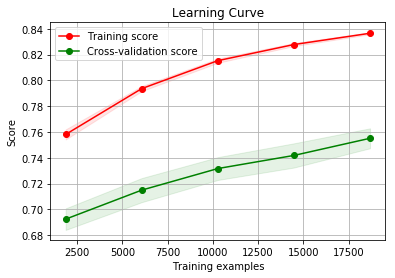

In [21]:
skplt.estimators.plot_learning_curve(model_lr,
                                     x_train,
                                     y_train,
                                     cv=C_V,
                                    random_state=RANDOM_STATE,
                                    n_jobs=N_JOBS,
                                    scoring=SCORING)
plt.show()

### Wykres słów najbardziej stymulujących skrajny sentyment według regresji

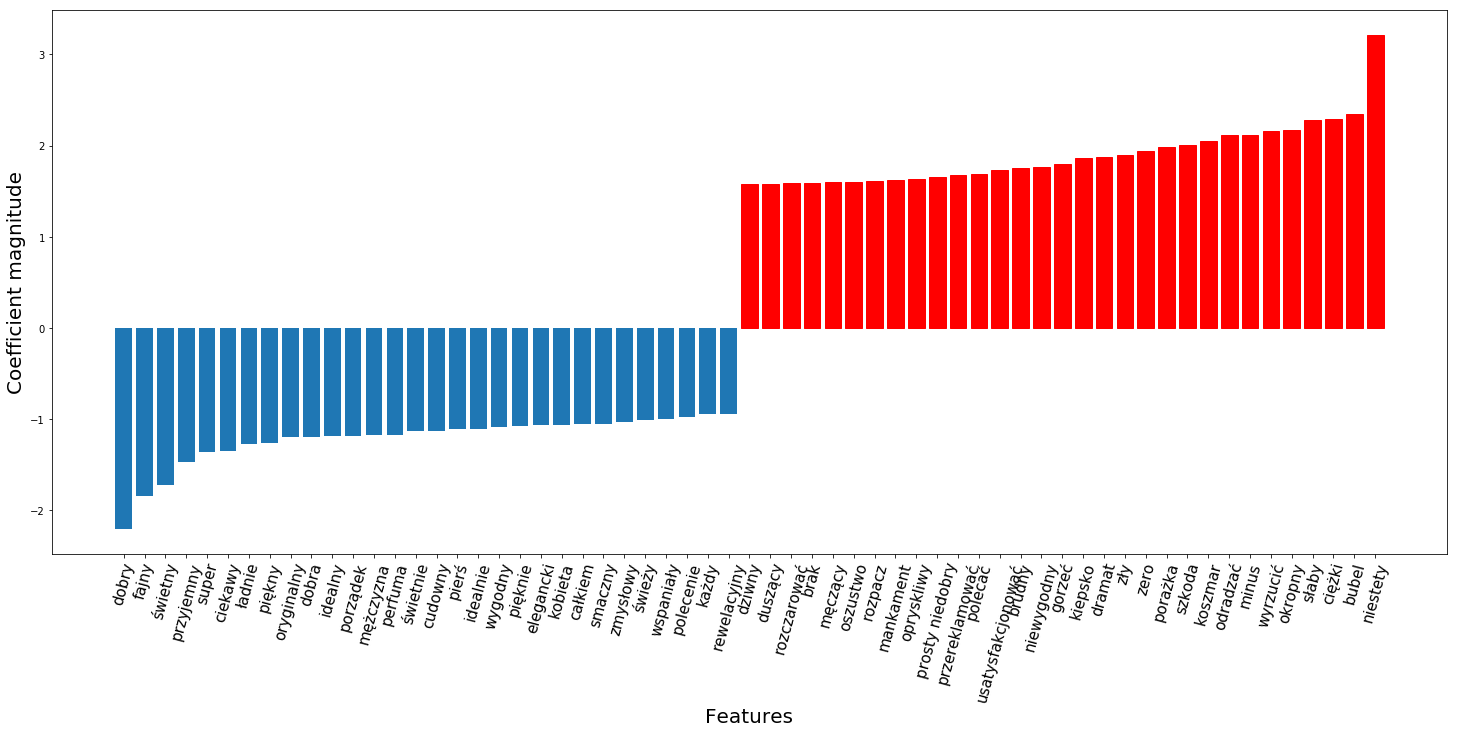

In [22]:
coefficients = model_lr.named_steps.get('lr').coef_
index = coefficients.argsort()

feature_names = np.array(model_lr.named_steps.get('tfidf').get_feature_names())
feature_names_comb = list(feature_names[index][0][:30]) + list(feature_names[index][0][-31::1])

index_comb = list(coefficients[0][index[0][:30]]) + list(coefficients[0][index[0][-31::1]])

plt.figure(figsize=(25,10))
barlist = plt.bar(list(i for i in range(61)), index_comb)
plt.xticks(list(i for i in range(61)),feature_names_comb,rotation=75,size=15)
plt.ylabel('Coefficient magnitude',size=20)
plt.xlabel('Features',size=20)

# color the first smallest 30 bars red
for i in range(30, 61):
    barlist[i].set_color('red')

plt.show()

### Zdefiniowanie funkcji wczytującej embeddingi, klasy procesującej dane do sieci neuronowej i samej sieci.

In [60]:
def non_trivial_sentence(sentence):
    len_words = [True if len(i) > 1 else 0 for i in sentence]
    return any(len_words)

def init(embeddings_type = 'w2v'): # function to load word embedding only once 
    if embeddings_type == 'w2v':    
        global w2vModel
        w2vModel = load_w2v_embeddings(W2V_PATH)
    else:
        raise NameError('Invalid embedding type {}'.format(embeddings_type))
        
def get_embeddings(embeddings_type = 'w2v'):
    if embeddings_type == 'w2v':
        global w2vModel
        try:
            return w2vModel
        except NameError:
            init(embeddings_type)
            return w2vModel
    else:
        raise NameError('Invalid embedding type %s' % embeddings_type)

def load_w2v_embeddings(path):
    w2vModel = gensim.models.KeyedVectors.load_word2vec_format(path, 
                                                               binary=False)
    return w2vModel 

class FixedSizeArray(BaseEstimator, TransformerMixin): # Transformer for transforming given data into undersoodable form for neural network
    def __init__(self, dimensions, steps, word2vec_mod=None):
        self.dim = dimensions
        self.steps = steps
        self.w2v = word2vec_mod
        
    def fit_transform(self, texts, y=None):
        return self.transform(texts, y)
    
    def fit(self, texts):
        return None
    
    def _transform(self, article):
        #tokens = CountVectorizer().build_tokenizer()(article) 
        doc_vectors_gen = (self.w2v[a].tolist() for a in article if a in self.w2v.vocab)
        doc_vectors = [a for (i, a) in enumerate(doc_vectors_gen) if i < self.steps]
        
        while len(doc_vectors) < self.steps:
            doc_vectors.append([0])
    
        pad_vectors = pad_sequences(doc_vectors,padding='post',dtype='float32', maxlen=self.dim, value=0.)
        return pad_vectors
    
    def transform(self, sentences, y=None):
        
        if self.w2v == None:
            print("Lazy loading embeddings...")
            self.w2v = get_embeddings('w2v')
        
        return np.array([self._transform(i) for i in sentences])
    
    
def plot_training(history): # plot training history
    plt.figure(figsize=(12, 12))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.figure(figsize=(12, 12))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    
def create_conv_model(dropout, input_shape, kernel_size=3): 
    model = Sequential()
    model.add(Conv1D(64, kernel_size, input_shape=(input_shape, 100), padding='same'))
    model.add(Conv1D(32, kernel_size, padding='same'))
    model.add(Conv1D(16, kernel_size, padding='same'))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(180, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax'))
    return model

def create_simple_LSTM_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape = (10, 100), return_sequences=True))
    model.add(SpatialDropout1D(0.5))
    model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(3,activation='softmax'))
    return model

def create_LSTM_model(input_shape):
    model = Sequential()
    model.add(LSTM(256, input_shape = (input_shape, 100), return_sequences=True, recurrent_dropout=0.2))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(128, return_sequences=True, recurrent_dropout=0.2))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    return model


def create_Dense_model():
    model = Sequential()
    model.add(Dense(64, input_shape=(1000,), activation='relu'))
    #model.add(Dense(8, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model


class NeuralNet(BaseEstimator, ClassifierMixin): 
    
    def __init__(self, model, name='', validation_size=0.2, batchsize = 256, epochs = 10):
        self.model = model
        self.model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
        self.early_stopping = EarlyStopping(patience=2) # early stopping callback
        self.checkpointer = ModelCheckpoint(filepath='{}_{}.h5'.format(name,
                                                                       time.time()), 
                                            verbose=1, 
                                            save_best_only=True) # save the best model
        self.tensorboard = TensorBoard(log_dir="logs/{}-{}".format(name,time.time())) # show results in the tensorboard
        self.batchsize = batchsize
        self.epochs = epochs
        self.validation_size = validation_size
        
    def fit(self, X, y):
        
        history = self.model.fit(X, 
                                 y, 
                                 validation_split=self.validation_size, 
                                 batch_size=self.batchsize, 
                                 epochs=self.epochs, 
                                 callbacks=[self.checkpointer, 
                                            self.early_stopping, 
                                            self.tensorboard] if self.validation_size != 0
                                else [self.checkpointer, self.tensorboard])
        self.history = history
        
    def predict(self, X):
        return self.model.predict(X)

In [24]:
def get_accuracy_score(estimator):
    pred = estimator.predict(x_test).argmax(axis=1)-1
    return accuracy_score(y_test, pred)

## Prosty dense

In [69]:
model_dense = create_Dense_model()

In [70]:
fsa = FixedSizeArray(100, 10)

In [71]:
a = fsa.transform(x_train)

Lazy loading embeddings...


In [72]:
a = a.reshape(-1, 10*100)

In [73]:
a.shape

(20767, 1000)

In [77]:
model_dense.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [78]:
model_dense.fit(a, dummy_y_train, epochs = 10)

Epoch 1/10
20767/20767 [==============================] - ETA: 5:30 - loss: 1.1149 - acc: 0.479 - ETA: 12s - loss: 0.6663 - acc: 0.706 - ETA: 6s - loss: 0.6019 - acc: 0.7337 - ETA: 4s - loss: 0.5663 - acc: 0.749 - ETA: 3s - loss: 0.5424 - acc: 0.756 - ETA: 2s - loss: 0.5223 - acc: 0.763 - ETA: 2s - loss: 0.5089 - acc: 0.769 - ETA: 1s - loss: 0.4952 - acc: 0.774 - ETA: 1s - loss: 0.4819 - acc: 0.781 - ETA: 1s - loss: 0.4743 - acc: 0.783 - ETA: 1s - loss: 0.4679 - acc: 0.786 - ETA: 0s - loss: 0.4576 - acc: 0.791 - ETA: 0s - loss: 0.4524 - acc: 0.793 - ETA: 0s - loss: 0.4467 - acc: 0.795 - ETA: 0s - loss: 0.4425 - acc: 0.796 - ETA: 0s - loss: 0.4368 - acc: 0.799 - ETA: 0s - loss: 0.4343 - acc: 0.800 - ETA: 0s - loss: 0.4297 - acc: 0.802 - ETA: 0s - loss: 0.4250 - acc: 0.805 - 1s 71us/step - loss: 0.4241 - acc: 0.8047
Epoch 2/10
20767/20767 [==============================] - ETA: 1s - loss: 0.2982 - acc: 0.833 - ETA: 0s - loss: 0.3249 - acc: 0.844 - ETA: 0s - loss: 0.3272 - acc: 0.848 - ET

20767/20767 [==============================] - ETA: 1s - loss: 0.2055 - acc: 0.927 - ETA: 0s - loss: 0.1356 - acc: 0.952 - ETA: 0s - loss: 0.1378 - acc: 0.949 - ETA: 0s - loss: 0.1422 - acc: 0.943 - ETA: 0s - loss: 0.1379 - acc: 0.945 - ETA: 0s - loss: 0.1372 - acc: 0.945 - ETA: 0s - loss: 0.1369 - acc: 0.945 - ETA: 0s - loss: 0.1378 - acc: 0.944 - ETA: 0s - loss: 0.1401 - acc: 0.944 - ETA: 0s - loss: 0.1388 - acc: 0.945 - ETA: 0s - loss: 0.1389 - acc: 0.944 - ETA: 0s - loss: 0.1387 - acc: 0.945 - ETA: 0s - loss: 0.1398 - acc: 0.944 - ETA: 0s - loss: 0.1419 - acc: 0.944 - ETA: 0s - loss: 0.1444 - acc: 0.943 - ETA: 0s - loss: 0.1468 - acc: 0.942 - ETA: 0s - loss: 0.1478 - acc: 0.942 - ETA: 0s - loss: 0.1493 - acc: 0.941 - ETA: 0s - loss: 0.1492 - acc: 0.941 - ETA: 0s - loss: 0.1502 - acc: 0.941 - 1s 48us/step - loss: 0.1519 - acc: 0.9409


### Prosty LSTM

In [ ]:
model_simple_lstm = Pipeline([
    ('fsa', FixedSizeArray(100,10)),
    ('nn', NeuralNet(create_simple_LSTM_model(10), 'simple_LSTM')),
])  # written classes can be used with sklearn Pipeline class

model_simple_lstm.fit(x_train, dummy_y_train)

plot_training(model_simple_lstm.steps[1][1].history) 

In [28]:
get_accuracy_score(model_simple_lstm)

0.7939972714870396

### LSTM

Lazy loading embeddings...
Train on 16613 samples, validate on 4154 samples
Epoch 1/10
16613/16613 [==============================] - ETA: 2:51 - loss: 0.6396 - acc: 0.666 - ETA: 1:36 - loss: 0.6323 - acc: 0.666 - ETA: 1:09 - loss: 0.6233 - acc: 0.667 - ETA: 56s - loss: 0.6159 - acc: 0.665 - ETA: 47s - loss: 0.6113 - acc: 0.66 - ETA: 42s - loss: 0.6054 - acc: 0.66 - ETA: 38s - loss: 0.6012 - acc: 0.67 - ETA: 35s - loss: 0.5910 - acc: 0.68 - ETA: 32s - loss: 0.5833 - acc: 0.69 - ETA: 30s - loss: 0.5820 - acc: 0.69 - ETA: 29s - loss: 0.5750 - acc: 0.70 - ETA: 27s - loss: 0.5678 - acc: 0.70 - ETA: 26s - loss: 0.5601 - acc: 0.71 - ETA: 25s - loss: 0.5560 - acc: 0.72 - ETA: 24s - loss: 0.5532 - acc: 0.72 - ETA: 23s - loss: 0.5483 - acc: 0.72 - ETA: 23s - loss: 0.5440 - acc: 0.72 - ETA: 22s - loss: 0.5390 - acc: 0.73 - ETA: 21s - loss: 0.5341 - acc: 0.73 - ETA: 20s - loss: 0.5283 - acc: 0.73 - ETA: 19s - loss: 0.5226 - acc: 0.74 - ETA: 19s - loss: 0.5175 - acc: 0.74 - ETA: 18s - loss: 0.5135

16613/16613 [==============================] - ETA: 26s - loss: 0.2449 - acc: 0.89 - ETA: 26s - loss: 0.2559 - acc: 0.89 - ETA: 25s - loss: 0.2683 - acc: 0.89 - ETA: 25s - loss: 0.2565 - acc: 0.89 - ETA: 25s - loss: 0.2577 - acc: 0.89 - ETA: 25s - loss: 0.2567 - acc: 0.89 - ETA: 25s - loss: 0.2584 - acc: 0.88 - ETA: 25s - loss: 0.2612 - acc: 0.88 - ETA: 26s - loss: 0.2563 - acc: 0.88 - ETA: 25s - loss: 0.2566 - acc: 0.88 - ETA: 25s - loss: 0.2608 - acc: 0.88 - ETA: 24s - loss: 0.2591 - acc: 0.88 - ETA: 24s - loss: 0.2607 - acc: 0.88 - ETA: 23s - loss: 0.2598 - acc: 0.88 - ETA: 23s - loss: 0.2594 - acc: 0.88 - ETA: 22s - loss: 0.2600 - acc: 0.88 - ETA: 22s - loss: 0.2601 - acc: 0.88 - ETA: 21s - loss: 0.2611 - acc: 0.88 - ETA: 20s - loss: 0.2609 - acc: 0.88 - ETA: 20s - loss: 0.2612 - acc: 0.88 - ETA: 20s - loss: 0.2617 - acc: 0.88 - ETA: 19s - loss: 0.2630 - acc: 0.88 - ETA: 19s - loss: 0.2607 - acc: 0.88 - ETA: 18s - loss: 0.2584 - acc: 0.88 - ETA: 18s - loss: 0.2585 - acc: 0.88 - ETA

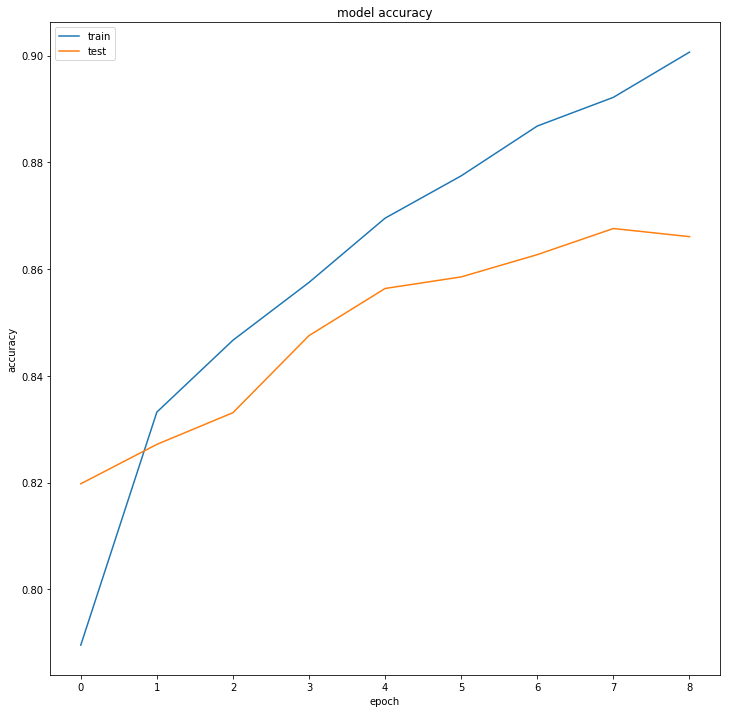

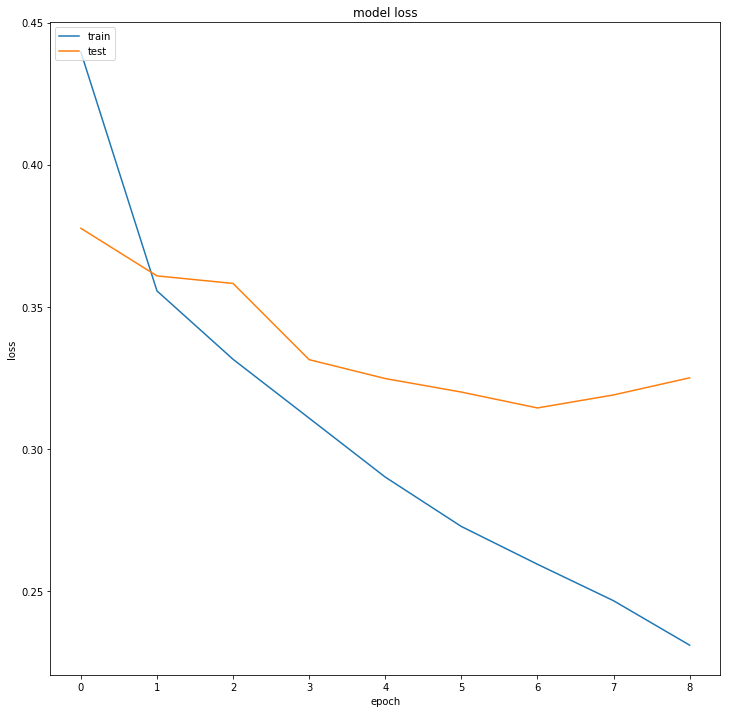

In [564]:
model_lstm = Pipeline([
    ('fsa', FixedSizeArray(100, 10)),
    ('nn', NeuralNet(create_LSTM_model(10), 'not_simple_LSTM')),
])

model_lstm.fit(x_train, dummy_y_train)

plot_training(model_lstm.steps[1][1].history) 

In [565]:
get_accuracy_score(model_lstm)

0.8021828103683493

### Conv1d

Lazy loading embeddings...
Train on 16613 samples, validate on 4154 samples
Epoch 1/10
16613/16613 [==============================] - ETA: 15s - loss: 0.8672 - acc: 0.60 - ETA: 3s - loss: 0.7702 - acc: 0.6560 - ETA: 1s - loss: 0.6937 - acc: 0.701 - ETA: 1s - loss: 0.6588 - acc: 0.723 - ETA: 1s - loss: 0.6381 - acc: 0.735 - ETA: 0s - loss: 0.6208 - acc: 0.740 - ETA: 0s - loss: 0.6002 - acc: 0.748 - ETA: 0s - loss: 0.5905 - acc: 0.752 - ETA: 0s - loss: 0.5818 - acc: 0.755 - ETA: 0s - loss: 0.5713 - acc: 0.758 - ETA: 0s - loss: 0.5578 - acc: 0.762 - ETA: 0s - loss: 0.5522 - acc: 0.764 - ETA: 0s - loss: 0.5445 - acc: 0.766 - 1s 66us/step - loss: 0.5421 - acc: 0.7672 - val_loss: 0.4248 - val_acc: 0.8040

Epoch 00001: val_loss improved from inf to 0.42481, saving model to conv_1d_1553241669.2142963.h5
Epoch 2/10
16613/16613 [==============================] - ETA: 0s - loss: 0.4615 - acc: 0.799 - ETA: 0s - loss: 0.4245 - acc: 0.812 - ETA: 0s - loss: 0.4333 - acc: 0.808 - ETA: 0s - loss: 0.435

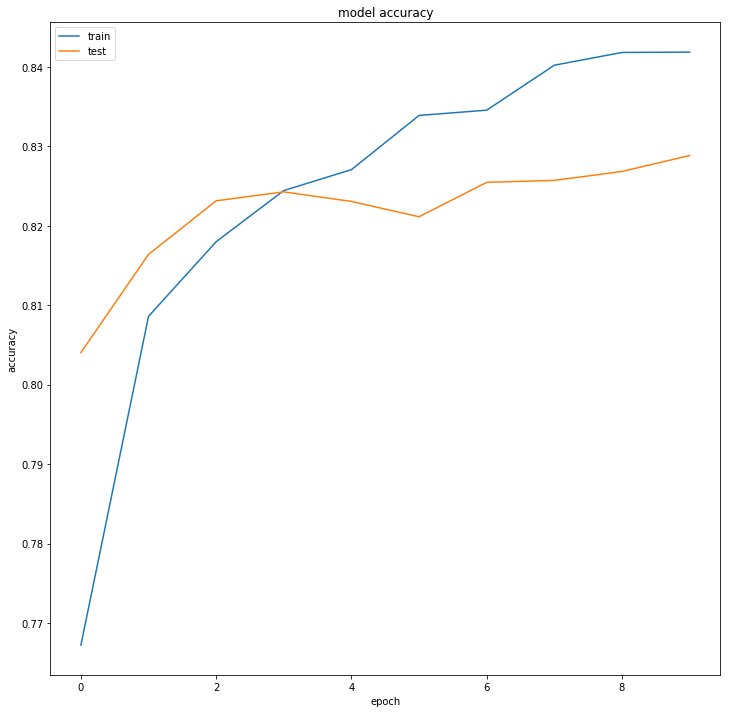

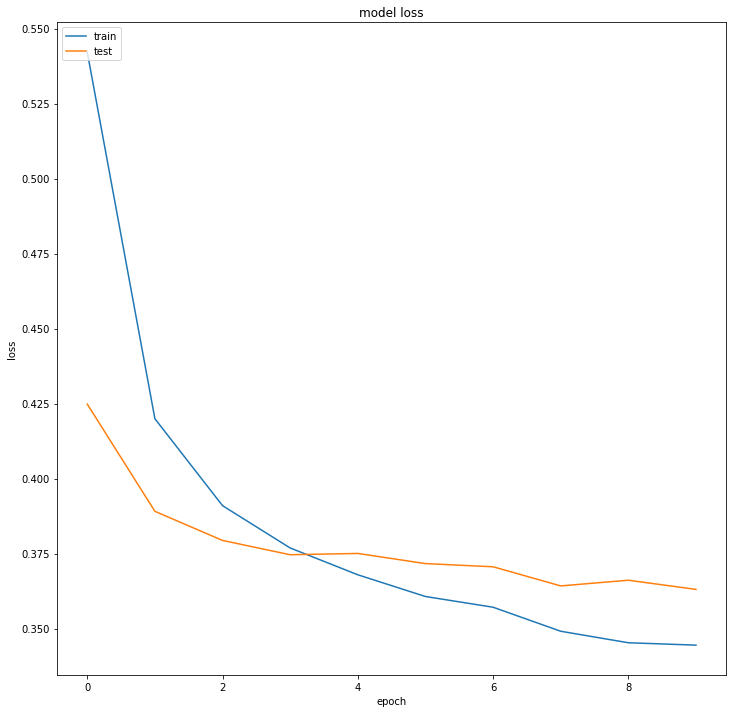

In [29]:
model_conv = Pipeline([
    ('fsa', FixedSizeArray(100, 10)),
    ('nn', NeuralNet(create_conv_model(0.3, 10), 'conv_1d')),
])

model_conv.fit(x_train, dummy_y_train)

plot_training(model_conv.steps[1][1].history) 

In [30]:
get_accuracy_score(model_conv)

0.7421555252387448

### Jak wczytać dane do challenge'u?

In [32]:
scoring_set = pd.read_csv("./data/challenge_set_warsztat.csv", sep = ';')
scoring_set = TokenizedDataFrame(stopwords).transform(scoring_set, 'token')

### Jak stworzyć i zapisać predykcję?

In [ ]:
# dla sklearn API
pred = model_lr.predict(scoring_set.token)

In [80]:
# dla Keras
pred = model_simple_lstm.predict(scoring_set.token).argmax(axis=1)-1

In [36]:
assert len(pred) == 5022

### Wektor zapisany przez np.save należy przesłać do nas na e-mail

In [79]:
np.save('nickname', pred)